# VISUM PT travel time ratio — preparation and analysis

This notebook prepares and analyzes public transport (PT) travel time ratios for the RVB VISUM project. It:

- Loads VISUM-derived zone/area/connector shapefiles and GTFS-based line geometries
- Reads PTV matrix files (usage, trips, transfers, car travel times)
- Enriches OD relations with PT metrics and zone attributes
- Builds filters for routing candidates and visual diagnostics (heatmaps, maps)
- Generates ReBus line buffers and intersects them with origin/destination zones

Inputs (repo-relative):
- `input/shapes/pt-data/*.SHP` zones, areas, connectors
- `input/mtx/*.mtx` PTV matrices (usage, trips, transfers, car_time)
- `input/gtfs-data/...` for GTFS routing context (optional)

Outputs (repo-relative examples):
- Derived Parquet/CSV under `output/`
- Diagnostic plots embedded in this notebook


## Contents

- 1. Setup and configuration
- 2. Data loading (zones, areas, connectors)
- 3. PTV matrices (usage, trips, transfers, car time)
- 4. Enrichment and merges (OD + attributes)
- 5. Filters and selections (routing candidates, heatmaps)
- 6. ReBus line buffers
- 7. Intersections and coverage (origins/destinations)
- 8. Plots and maps
- Appendix: How to run and publish

In [27]:
# -*- coding: utf-8 -*-
# Notebook cell: Read areas and connectors

import os
# Avoid PyGEOS/GEOS mismatch warnings and force Shapely backend
os.environ["USE_PYGEOS"] = "0"

import sys
from pathlib import Path

# Ensure we can import the local package `gtfs_routing` (sibling of this folder)
_nb_dir = Path.cwd().resolve()
_pkg_root = _nb_dir.parent  # src/pt-traveltimeratio
if str(_pkg_root) not in sys.path:
    sys.path.insert(0, str(_pkg_root))

import geopandas as gpd
import pandas as pd

from matrixconverters.read_ptv import ReadPTVMatrix

## 1. Setup and configuration

Environment, repo-relative paths, parameters, and small helper utilities used throughout the notebook.

In [ ]:
# Configuration and parameters (safe defaults)
# This cell sets defaults only if variables are not already defined in the runtime.

from pathlib import Path
import os
import pandas as pd

# Debug/publish toggles
DEBUG = bool(os.environ.get('PT_DEBUG', '0') == '1') if 'DEBUG' not in globals() else DEBUG
PUBLISH_MODE = bool(os.environ.get('PT_PUBLISH', '0') == '1') if 'PUBLISH_MODE' not in globals() else PUBLISH_MODE

# Display settings for clean outputs
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Repo root detection
if 'repo_root' not in globals():
    here = Path.cwd()
    # Find the repo root by locating requirements.txt
    for p in [here] + list(here.parents):
        if (p / 'requirements.txt').exists():
            repo_root = p
            break
    else:
        repo_root = here

# Input/output directories
if 'shapes_dir' not in globals():
    shapes_dir = repo_root / 'input' / 'shapes' / 'pt-data'
if 'mtx_dir' not in globals():
    mtx_dir = repo_root / 'input' / 'mtx'
if 'output_dir' not in globals():
    output_dir = repo_root / 'output'
    output_dir.mkdir(parents=True, exist_ok=True)

# Common thresholds (used in filters)
usage_min = globals().get('usage_min', 0.90)
transfers_max_exclusive = globals().get('transfers_max_exclusive', 2)
trips_min = globals().get('trips_min', 5)
BUFFER_METERS = globals().get('BUFFER_METERS', 300.0)

# Column name conventions
ORIGIN_COL = globals().get('ORIGIN_COL', 'origins')
DEST_COL = globals().get('DEST_COL', 'destinations')
KEY_ORIGIN = globals().get('KEY_ORIGIN', 'NO')
KEY_DEST = globals().get('KEY_DEST', 'NO')
WKT_COL = globals().get('WKT_COL', 'geometry')
SRC_COL = globals().get('SRC_COL', 'LINENAME')

print(f"Repo root: {repo_root}")
print(f"Input dirs: shapes={shapes_dir}, mtx={mtx_dir}")
print(f"Output dir: {output_dir}")
print(f"Params: usage_min={usage_min}, transfers_max_exclusive={transfers_max_exclusive}, trips_min={trips_min}, BUFFER_METERS={BUFFER_METERS}")

In [248]:
# Basisverzeichnis relativ zum Repo bestimmen (Notebook: kein __file__, daher über CWD gehen)
from pathlib import Path

cwd = Path.cwd().resolve()
# Suche nach Repo-Root: gehe nach oben bis Ordner mit 'input/shapes/pt-data' gefunden wird
repo_root = None
here = cwd
for _ in range(8):
    if (here / "input" / "shapes" / "pt-data").exists():
        repo_root = here
        break
    if here.parent == here:
        break
    here = here.parent

if repo_root is None:
    raise RuntimeError("Konnte Repo-Root nicht finden (input/shapes/pt-data fehlt). Bitte Notebook im Repo ausführen.")

shapes_dir = repo_root / "input" / "shapes" / "pt-data"
output_dir = repo_root / "output" / "scenario_V10_2025"

# Shapefiles (exakt nach Ordnerinhalt)
area_file = shapes_dir / "V10_2025_area.SHP"
zone_file = shapes_dir / "V10_2025_zone.SHP"
connector_file = shapes_dir / "V10_2025_connector.SHP"

In [ ]:
# Helper functions for this notebook
import logging
import geopandas as gpd

logging.basicConfig(level=logging.INFO if not globals().get('DEBUG', False) else logging.DEBUG, format='[%(levelname)s] %(message)s')
log = logging.getLogger(__name__)

def debug(msg: str):
    if globals().get('DEBUG', False):
        log.debug(msg)

def ensure_projected(gdf: gpd.GeoDataFrame, target_epsg: int = 32632) -> gpd.GeoDataFrame:
    """Return GeoDataFrame in a projected CRS suitable for buffering (defaults to UTM32N)."""
    if gdf is None or gdf.empty:
        return gdf
    if gdf.crs is None:
        return gdf.set_crs(epsg=target_epsg)
    if gdf.crs.to_epsg() == target_epsg:
        return gdf
    try:
        return gdf.to_crs(epsg=target_epsg)
    except Exception as e:
        log.warning(f"CRS transform failed, keeping original CRS: {e}")
        return gdf

def unique_by_geometry(gdf: gpd.GeoDataFrame, geom_col: str = 'geometry') -> gpd.GeoDataFrame:
    """Drop duplicated geometries using WKB fingerprint; keep first occurrence."""
    if gdf is None or gdf.empty:
        return gdf
    tmp = gdf.copy()
    tmp['_wkb'] = tmp[geom_col].apply(lambda g: g.wkb if g is not None else b'')
    tmp = tmp.drop_duplicates(subset=['_wkb']).drop(columns=['_wkb'])
    return tmp

print("Helpers ready (debug, ensure_projected, unique_by_geometry)")

In [ ]:
# Helper: add connector counts (origin/destination) to a routing DataFrame
from typing import Optional

def add_connector_counts(
    routing_df: pd.DataFrame,
    connectors_gdf: gpd.GeoDataFrame,
    zones_with_endpoints: Optional[gpd.GeoDataFrame] = None,
    origin_col: str = 'origins',
    dest_col: str = 'destinations',
    zone_id_col: str = 'NO',
    connectors_zone_col: str = 'ZONENO'
) -> pd.DataFrame:
    """
    Add two integer columns to routing_df:
      - n_connectors_origin
      - n_connectors_destination
    Counts are derived from zones_with_endpoints['n_connectors'] if provided,
    otherwise by grouping connectors_gdf by its zone column.
    """
    if origin_col not in routing_df.columns or dest_col not in routing_df.columns:
        raise KeyError(f"routing_df must contain '{origin_col}' and '{dest_col}' columns")
    # Try zones_with_endpoints first
    if zones_with_endpoints is not None and 'n_connectors' in zones_with_endpoints.columns:
        zkey = zone_id_col if zone_id_col in zones_with_endpoints.columns else zones_with_endpoints.columns[0]
        counts_series = zones_with_endpoints.set_index(zkey)['n_connectors']
    else:
        ckey = connectors_zone_col if connectors_zone_col in connectors_gdf.columns else (
            'zone_id' if 'zone_id' in connectors_gdf.columns else None
        )
        if ckey is None:
            raise KeyError("connectors_gdf must have 'ZONENO' or 'zone_id' to group by zone")
        counts_series = connectors_gdf.groupby(ckey).size()
    counts_df = counts_series.rename('n_connectors').to_frame().reset_index().rename(columns={counts_series.index.name: 'zone_id_key'})

    out = routing_df.copy()
    out = out.merge(counts_df, left_on=origin_col, right_on='zone_id_key', how='left').rename(
        columns={'n_connectors': 'n_connectors_origin'}
    ).drop(columns=['zone_id_key'])
    out = out.merge(counts_df, left_on=dest_col, right_on='zone_id_key', how='left').rename(
        columns={'n_connectors': 'n_connectors_destination'}
    ).drop(columns=['zone_id_key'])

    out['n_connectors_origin'] = out['n_connectors_origin'].fillna(0).astype(int)
    out['n_connectors_destination'] = out['n_connectors_destination'].fillna(0).astype(int)
    return out

In [13]:
# Einlesen mit GeoPandas
print("Reading shapefiles...")

# Mit Encoding lesen (probier cp1252 oder latin1)
encoding = "latin1"
print("Reading shapefiles with encoding:", encoding)


gdf_area = gpd.read_file(area_file, encoding=encoding)
print(f"Areas loaded: {len(gdf_area)} records")

gdf_zones = gpd.read_file(zone_file, encoding=encoding)
print(f"Zones loaded: {len(gdf_zones)} records")

gdf_connectors = gpd.read_file(connector_file, encoding=encoding)
print(f"Connectors loaded: {len(gdf_connectors)} records")

# Optional: CRS prüfen
print("CRS (area):", gdf_area.crs)
print("CRS (zone):", gdf_zones.crs)
print("CRS (connector):", gdf_connectors.crs)

Reading shapefiles...
Reading shapefiles with encoding: latin1
Areas loaded: 20 records
Zones loaded: 2118 records


Reading shapefiles...
Reading shapefiles with encoding: latin1
Areas loaded: 20 records
Zones loaded: 2118 records


c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '0.00' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 0.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '0.00' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 0.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '1.59' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 1.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '168.79' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 168.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '11.42' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 11

Reading shapefiles...
Reading shapefiles with encoding: latin1
Areas loaded: 20 records
Zones loaded: 2118 records


c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '0.00' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 0.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '0.00' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 0.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '1.59' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 1.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '168.79' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 168.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '11.42' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 11

Connectors loaded: 8408 records
CRS (area): EPSG:32632
CRS (zone): EPSG:32632
CRS (connector): EPSG:32632


c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '1812.64' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 1812.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '256.75' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 256.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '3251.49' of field V10_2025_connector.R_GEWIC~15 parsed incompletely to integer 3251.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '66.81' of field V10_2025_connector.R_GEWIC~14 parsed incompletely to integer 66.
  return ogr_read(
c:\Users\bienzeisler\Anaconda3\envs\geo_env\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Value '1431.14' of field V10_2025_connector.R_GEWIC~15 parsed incomplete

## 2. Data loading (zones, areas, connectors)

Read shapefiles for study area, zones, and connector lines. All paths are repo-relative and encoding is set to Latin-1 for legacy data.

In [25]:
# Filter alle PT-Connectors (FGV im TSYSSET)
FGV_connectors = gdf_connectors[
    gdf_connectors["TSYSSET"].str.contains("FGV", na=False)
]

print(f"Found PT connectors: {len(FGV_connectors)} of {len(gdf_connectors)} total")
print(FGV_connectors["TSYSSET"].unique())


Found PT connectors: 4245 of 8408 total
['FGV,Rad' 'FGV,Lkw-g,Lkw-k,Lkw-m,Lkw-t,Pkw,Rad'
 'FGV,Lkw-g,Lkw-k,Lkw-m,Lkw-t,OEVFUSS,Pkw,Rad' 'FGV,Pkw,Rad'
 'FGV,Lkw-k,OEVFUSS,Pkw,Rad' 'FGV,Lkw-k,Pkw,Rad'
 'FGV,Lkw-g,Lkw-k,Lkw-m,Pkw,Rad' 'FGV,Lkw-g,Lkw-k,Lkw-m,Lkw-t,Pkw']


Connectors gefunden: 4 für ZONENO=310129901
Zonen gefunden: 1 mit NAME=BS Alt - Lehndorf 1


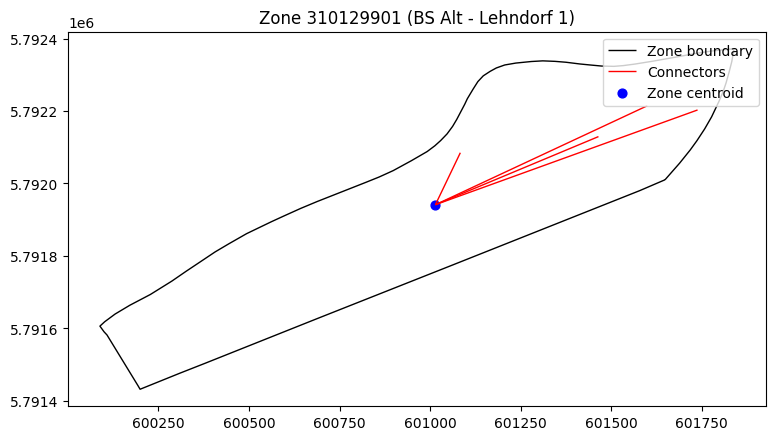

In [15]:
import matplotlib.pyplot as plt

zone_id = 310129901

# Filter connectors über ZONENO
conn_sub = FGV_connectors[FGV_connectors["ZONENO"] == zone_id]

# Filter zones über NO
zone_sub = gdf_zones[gdf_zones["NO"] == zone_id]

# Zonename für den Titel
zone_name = None
if not zone_sub.empty and "NAME" in zone_sub.columns:
    zone_name = zone_sub.iloc[0]["NAME"]

print(f"Connectors gefunden: {len(conn_sub)} für ZONENO={zone_id}")
print(f"Zonen gefunden: {len(zone_sub)} mit NAME={zone_name}")

# Plot
fig, ax = plt.subplots(figsize=(9, 9))

# Zone zeichnen
if not zone_sub.empty:
    zone_sub.boundary.plot(ax=ax, color="black", linewidth=1, label="Zone boundary")

# Connectors zeichnen
if not conn_sub.empty:
    conn_sub.plot(ax=ax, color="red", linewidth=1, label="Connectors")

# Optional: Centroid berechnen und plotten
if not zone_sub.empty:
    zone_sub.centroid.plot(ax=ax, color="blue", markersize=40, label="Zone centroid")

# Titel
title = f"Zone {zone_id}"
if zone_name:
    title += f" ({zone_name})"
ax.set_title(title)

ax.legend()
plt.show()


C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_23596\4026306420.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  zone_centroid: Point = zone_sub.geometry.unary_union.centroid


Computed far endpoints for 4 connectors


C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_23596\4026306420.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  zone_centroid: Point = zone_sub.geometry.unary_union.centroid


Computed far endpoints for 4 connectors


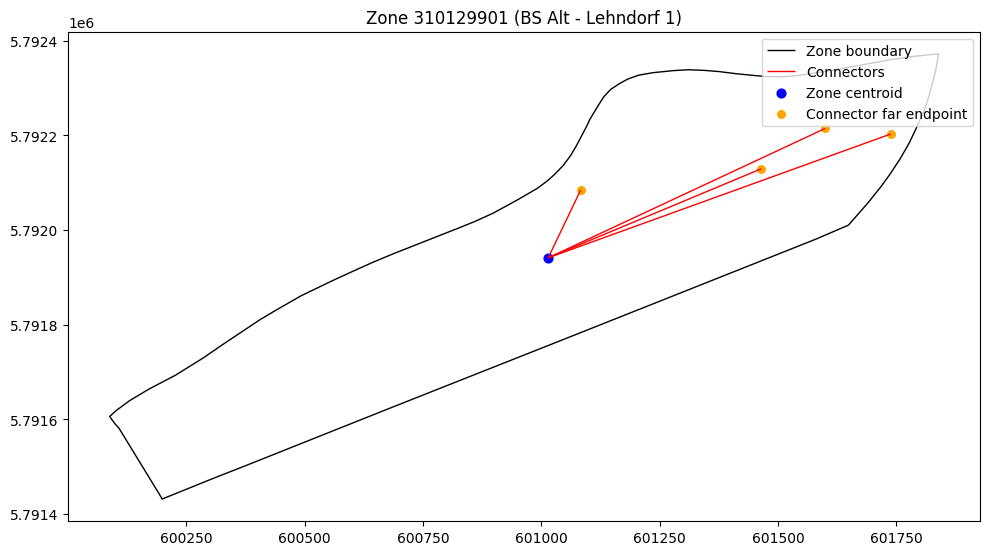

In [16]:
from shapely.geometry import Point, LineString, MultiLineString
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Annahme: zone_sub und conn_sub sind bereits gefiltert (eine Zone, nur PT-Connectors dieser Zone)
# CRS ist vereinheitlicht (z. B. EPSG:3857 oder dein Projekt-CRS)

# Referenzpunkt = Zonen-Centroid
if zone_sub.empty:
    raise ValueError("zone_sub is empty")
zone_centroid: Point = zone_sub.geometry.unary_union.centroid

def far_endpoint(geom, ref_pt: Point) -> Point:
    """Return the endpoint of a connector geometry that is farthest from ref_pt."""
    if geom is None or geom.is_empty:
        return None

    def endpts_ls(ls: LineString):
        c = list(ls.coords)
        return Point(c[0]), Point(c[-1])

    far_pt = None
    far_d = -1.0

    if isinstance(geom, LineString):
        p0, p1 = endpts_ls(geom)
        for p in (p0, p1):
            d = ref_pt.distance(p)
            if d > far_d:
                far_d, far_pt = d, p

    elif isinstance(geom, MultiLineString):
        for ls in geom.geoms:
            p0, p1 = endpts_ls(ls)
            for p in (p0, p1):
                d = ref_pt.distance(p)
                if d > far_d:
                    far_d, far_pt = d, p
    else:
        # Falls mal ein anderer Typ auftaucht: auf den Centroid der Geometrie ausweichen
        p = geom.representative_point()
        far_pt = p

    return far_pt

# Endpunkte berechnen
end_points = []
rows = []
for idx, row in conn_sub.iterrows():
    geom = row.geometry
    p = far_endpoint(geom, zone_centroid)
    if p is not None:
        end_points.append(p)
        rows.append(row)

# GeoDataFrame der Endpunkte
gdf_endpts = gpd.GeoDataFrame(
    rows,
    geometry=end_points,
    crs=conn_sub.crs
)

print(f"Computed far endpoints for {len(gdf_endpts)} connectors")

# Plot: Zone, Connectors, Centroid, far Endpoints
fig, ax = plt.subplots(figsize=(10, 8))

# Zone
zone_sub.boundary.plot(ax=ax, color="black", linewidth=1, label="Zone boundary")

# Connectors
conn_sub.plot(ax=ax, color="red", linewidth=1, label="Connectors")

# Centroid
gpd.GeoSeries([zone_centroid], crs=zone_sub.crs).plot(ax=ax, color="blue", markersize=40, label="Zone centroid")

# Far endpoints
gdf_endpts.plot(ax=ax, color="orange", markersize=30, label="Connector far endpoint")

# Titel
zone_id = int(zone_sub.iloc[0]["NO"]) if "NO" in zone_sub.columns else None
zone_name = zone_sub.iloc[0]["NAME"] if "NAME" in zone_sub.columns else None
title = f"Zone {zone_id}" if zone_id is not None else "Zone"
if zone_name:
    title += f" ({zone_name})"
ax.set_title(title)

ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Requirements (only once):
# %pip install tqdm

import logging
from typing import List, Optional
from shapely.geometry import Point, LineString, MultiLineString
import geopandas as gpd
from tqdm import tqdm

# --------------------------------------------------------------------
# Logging
# --------------------------------------------------------------------
logging.basicConfig(level=print, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger("pt-endpoints")

# --------------------------------------------------------------------
# Geometry helpers
# --------------------------------------------------------------------
def _far_endpoint(geom, ref_pt: Point) -> Optional[Point]:
    """
    Return the endpoint of a connector geometry that is farthest from ref_pt.
    Handles LineString and MultiLineString. Falls back to representative_point.
    """
    if geom is None or geom.is_empty:
        return None

    def endpts_ls(ls: LineString):
        c = list(ls.coords)
        return Point(c[0]), Point(c[-1])

    far_pt = None
    far_d = -1.0

    if isinstance(geom, LineString):
        p0, p1 = endpts_ls(geom)
        for p in (p0, p1):
            d = ref_pt.distance(p)
            if d > far_d:
                far_d, far_pt = d, p

    elif isinstance(geom, MultiLineString):
        for ls in geom.geoms:
            p0, p1 = endpts_ls(ls)
            for p in (p0, p1):
                d = ref_pt.distance(p)
                if d > far_d:
                    far_d, far_pt = d, p
    else:
        # Fallback for unexpected geometry types
        far_pt = geom.representative_point()

    return far_pt

# --------------------------------------------------------------------
# Main function
# --------------------------------------------------------------------
def attach_far_endpoints_per_zone(
    zones: gpd.GeoDataFrame,
    connectors: gpd.GeoDataFrame,
    zone_id_col: str = "NO",          # zone id column in zones
    conn_zone_col: str = "ZONENO",    # zone id column in connectors
    endpoints_col: str = "connector_far_endpoints",
    n_connectors_col: str = "n_connectors",
) -> gpd.GeoDataFrame:
    """
    For each zone, find its connectors, compute far endpoints relative to the
    zone centroid, and store them as a list of Points in a new column.

    Returns a copy of `zones` with two new columns:
      - endpoints_col: list[Point] with one far endpoint per connector
      - n_connectors_col: int number of connectors considered
    """
    if zones.empty:
        raise ValueError("zones is empty")
    if connectors.empty:
        log.warning("connectors is empty; result columns will be empty lists.")

    # Make a copy to avoid mutating caller data
    zones_out = zones.copy()

    # Ensure a common CRS (project if needed)
    target_crs = zones_out.crs or connectors.crs
    if target_crs is None:
        raise ValueError("No CRS set on inputs. Please set CRS on zones/connectors.")

    if connectors.crs != target_crs:
        log.info("Projecting connectors to zones CRS.")
        connectors = connectors.to_crs(target_crs)

    # Precompute per-zone grouping for fast lookup
    log.info("Indexing connectors by zone id.")
    groups = connectors.groupby(conn_zone_col)

    # Prepare result columns
    zones_out[endpoints_col] = [[] for _ in range(len(zones_out))]
    zones_out[n_connectors_col] = 0

    # Iterate with progress bar
    log.info("Computing far endpoints per zone.")
    for i, row in tqdm(list(zones_out.iterrows()), total=len(zones_out)):
        zone_id = row[zone_id_col]
        geom = row.geometry
        if geom is None or geom.is_empty:
            # leave defaults (empty list, 0)
            continue

        centroid: Point = geom.centroid

        # Fetch connectors for this zone id
        try:
            conns_zone = groups.get_group(zone_id)
        except KeyError:
            # no connectors for this zone
            continue

        far_points: List[Point] = []
        for _, crow in conns_zone.iterrows():
            p = _far_endpoint(crow.geometry, centroid)
            if p is not None:
                far_points.append(p)

        zones_out.at[i, endpoints_col] = far_points
        zones_out.at[i, n_connectors_col] = len(far_points)

    log.info("Done computing endpoints.")
    return zones_out


In [18]:
zones_with_endpoints = attach_far_endpoints_per_zone(
    zones=gdf_zones,
    connectors=FGV_connectors,
    zone_id_col="NO",
    conn_zone_col="ZONENO",
    endpoints_col="connector_far_endpoints",
    n_connectors_col="n_connectors"
)


2025-09-04 14:13:12,838 INFO Indexing connectors by zone id.
2025-09-04 14:13:12,838 INFO Computing far endpoints per zone.
2025-09-04 14:13:12,838 INFO Computing far endpoints per zone.
100%|██████████| 2118/2118 [00:01<00:00, 1627.93it/s]
2025-09-04 14:13:14,256 INFO Done computing endpoints.
100%|██████████| 2118/2118 [00:01<00:00, 1627.93it/s]
2025-09-04 14:13:14,256 INFO Done computing endpoints.


In [19]:
# Quick sanity check for one zone
zid = 310129901
row = zones_with_endpoints.loc[zones_with_endpoints["NO"] == zid].iloc[0]
print("zone:", zid, "n_connectors:", row["n_connectors"])
print("Endpoints:", row["connector_far_endpoints"])

zone: 310129901 n_connectors: 4
Endpoints: [<POINT (601599.594 5792214.543)>, <POINT (601083.482 5792084.906)>, <POINT (601464.824 5792129.438)>, <POINT (601738.397 5792202.934)>]


In [ ]:
from shapely.geometry import MultiPoint
from shapely import wkt
import geopandas as gpd
from pathlib import Path

SRC_COL = "connector_far_endpoints"     # list[Point]
WKT_COL = "connector_far_end_wkt"       # str

# Ausgabeordner relativ zum Repo (nutzt repo_root aus vorheriger Zelle)
output_dir.mkdir(parents=True, exist_ok=True)
parquet_path = output_dir / "zones_with_endpoints.parquet"

def pack_points_to_wkt(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    z = gdf.copy()
    z[WKT_COL] = z[SRC_COL].apply(
        lambda pts: MultiPoint(pts).wkt if pts else None
    )
    return z.drop(columns=[SRC_COL])

def unpack_wkt_to_points(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    z = gdf.copy()
    def _to_pts(s):
        if not s:
            return []
        mp = wkt.loads(s)
        return list(mp.geoms)  # list[Point]
    z[SRC_COL] = z[WKT_COL].apply(_to_pts)
    return z

# speichern
z_out = pack_points_to_wkt(zones_with_endpoints)
z_out.to_parquet(parquet_path, index=False)
print("Saved:", parquet_path)

Saved: C:\Users\bienzeisler\RVB-VISUM-analysis\output\scenario_V10_2025\zones_with_endpoints.parquet


In [21]:
parquet_path = repo_root / "output" / "scenario_V10_2025" / "zones_with_endpoints.parquet"
zones_with_endpoints_import = gpd.read_parquet(parquet_path)


In [22]:
class GTFSRouteLookup:
    def __init__(self, gtfs_zip_path):
        self.routes = self._load_routes(gtfs_zip_path)

    GTFS_ROUTE_TYPES = {
        0: "Tram / Light Rail",
        1: "Subway / Metro",
        2: "Rail",
        3: "Bus",
        4: "Ferry",
        5: "Cable Car",
        6: "Gondola / Suspended Cable Car",
        7: "Funicular"}

    def _load_routes(self, gtfs_zip_path):
        return pd.read_csv(gtfs_zip_path)[["route_id", "route_short_name", "route_type"]]

    def get_route_info(self, route_id):
        match = self.routes[self.routes["route_id"] == route_id]
        if not match.empty:
            return match.iloc[0]["route_short_name"], self.GTFS_ROUTE_TYPES.get(match.iloc[0]["route_type"], "Unknown")
        return None, None

In [23]:
from gtfs_routing.transit_router import TransitRouter

csv_path = repo_root / "input" / "gtfs-data" / "2025(V10)" / "routes.txt"

router = TransitRouter()

gtfs_route_lookup = GTFSRouteLookup(csv_path)
routes = pd.read_csv(csv_path)

In [26]:
import random

departure_time="2025-05-13T08:00:00Z"

coords_list = []
# Grobes Bounding Box für Braunschweig
# (min_lon, min_lat, max_lon, max_lat)
bbox = (10.45, 52.22, 10.60, 52.32)

coords_list = []

for _ in range(2):  # 2 zufällige Koordinatenpaare
    origin_lat = random.uniform(bbox[1], bbox[3])
    origin_lon = random.uniform(bbox[0], bbox[2])
    dest_lat = random.uniform(bbox[1], bbox[3])
    dest_lon = random.uniform(bbox[0], bbox[2])
    
    coords_list.append((origin_lat, origin_lon, dest_lat, dest_lon))

print(coords_list)

print(" - Calculating routes...")
results = await router.batch_pt_routes(coords_list, departure_time=departure_time)
results


[(52.307020550893284, 10.57826729269568, 52.22088875247799, 10.45895736298647), (52.30464223772872, 10.466976074425139, 52.25256147164001, 10.579455634765939)]
 - Calculating routes...


[(52.307020550893284, 10.57826729269568, 52.22088875247799, 10.45895736298647), (52.30464223772872, 10.466976074425139, 52.25256147164001, 10.579455634765939)]
 - Calculating routes...


[{'hints': {'visited_nodes.sum': 204785, 'visited_nodes.average': 204785},
  'info': {'copyrights': ['GraphHopper', 'OpenStreetMap contributors'],
   'took': 310},
  'paths': [{'distance': 2947.758,
    'weight': 5627667.0,
    'time': 5627667,
    'transfers': 2,
    'points_encoded': False,
    'bbox': [10.450009, 52.22087, 10.577408, 52.307442],
    'points': {'type': 'LineString',
     'coordinates': [[10.577408, 52.307442],
      [10.577251, 52.307434],
      [10.576449, 52.307109],
      [10.576344, 52.307116],
      [10.574176, 52.306203],
      [10.57439, 52.305333],
      [10.574488, 52.305174],
      [10.57503, 52.30487],
      [10.57503, 52.30487],
      [10.56853, 52.30093],
      [10.56172, 52.29724],
      [10.5606, 52.29252],
      [10.56119, 52.29026],
      [10.56443, 52.28517],
      [10.561333, 52.282246],
      [10.557982, 52.278617],
      [10.550381, 52.277167],
      [10.550381, 52.277167],
      [10.550381, 52.277167],
      [10.54445, 52.27586],
      [10.54011

In [61]:
# Read PTV matrices (repo-relative, English variable names)
from pathlib import Path
import shutil
import re

# Ensure repo_root and mtx_dir are defined (set earlier in the notebook)
try:
    _ = repo_root
except NameError:
    # Derive repo_root from CWD as in earlier cells
    cwd = Path.cwd().resolve()
    repo_root = cwd
    for _ in range(8):
        if (repo_root / "input" / "shapes" / "pt-data").exists():
            break
        if repo_root.parent == repo_root:
            break
        repo_root = repo_root.parent

mtx_dir = repo_root / "input" / "mtx" / "backup"

# Matrix files (English variable names)
mtx_pt_trips = mtx_dir / "3 OEV PV.mtx"
mtx_usage_rebus = mtx_dir / "Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx"
mtx_pt_transfers = mtx_dir / "173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx"
# mtx_car_time = mtx_dir / "221 RZ Pkw präp.mtx"
mtx_car_time = mtx_dir / "TTM_PKW_präp.mtx"  # Using OEV travel time as a proxy for car time

print("Matrix files (repo-relative):")
print("- PT trips:", mtx_pt_trips)
print("- Usage (ReBus):", mtx_usage_rebus)
print("- PT transfers (MUH):", mtx_pt_transfers)
print("- Car time (RZ Pkw):", mtx_car_time)

# Existence checks
for p in [mtx_pt_trips, mtx_usage_rebus, mtx_pt_transfers, mtx_car_time]:
    print(f"exists={p.exists()} size={(p.stat().st_size if p.exists() else 'n/a')} -> {p}")

# Read with ReadPTVMatrix if available
try:
    _ = ReadPTVMatrix
except NameError:
    raise RuntimeError("ReadPTVMatrix is not available in this kernel. Please import/define it before reading matrices.")

# Create datasets (use English dataset names)

pt_trips_matrix = ReadPTVMatrix(filename=str(mtx_pt_trips))
usage_rebus_matrix = ReadPTVMatrix(filename=str(mtx_usage_rebus))
pt_transfers_matrix = ReadPTVMatrix(filename=str(mtx_pt_transfers))
car_time_matrix = ReadPTVMatrix(filename=str(mtx_car_time))


Matrix files (repo-relative):
- PT trips: C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\3 OEV PV.mtx
- Usage (ReBus): C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx
- PT transfers (MUH): C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx
- Car time (RZ Pkw): C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\TTM_PKW_präp.mtx
exists=True size=34435421 -> C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\3 OEV PV.mtx
exists=True size=16470671 -> C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx
exists=True size=25409795 -> C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx
exists=True size=35343196 -> C:\Users\bienzeisler\RVB-VISUM-analysis\input\mtx\backup\TTM_PKW_präp.mtx


## 6. ReBus line buffers

Load line routes, filter to ReBus, and create dissolved buffers per LINENAME (default 300 m). Ensure projected CRS before buffering.

In [66]:
# Convert PTV matrices to Pandas DataFrames (English variables, consistent schema)
import xarray as xr

def _matrix_dataarray(ds: xr.Dataset):
    """Return the primary matrix DataArray from a dataset (fallback to first data var)."""
    if "matrix" in ds:
        return ds["matrix"]
    # fallback: first variable
    try:
        name = next(iter(ds.data_vars))
        return ds[name]
    except StopIteration:
        raise ValueError("PTV matrix dataset contains no data variables.")

# Extract DataArrays
da_pt_trips = _matrix_dataarray(pt_trips_matrix)           # 3 OEV PV.mtx
da_usage_rebus = _matrix_dataarray(usage_rebus_matrix)     # 3000061 PS(ReBus) ...
da_pt_transfers = _matrix_dataarray(pt_transfers_matrix)   # 173 MUH ...
da_car_time = _matrix_dataarray(car_time_matrix)           # 221 RZ Pkw präp.mtx

# To DataFrames (origins, destinations, value)
df_pt_trips = da_pt_trips.to_dataframe(name="value").reset_index()
df_usage_rebus = da_usage_rebus.to_dataframe(name="value").reset_index()
df_pt_transfers = da_pt_transfers.to_dataframe(name="value").reset_index()
df_car_time = da_car_time.to_dataframe(name="value").reset_index()

# Optional: set index for fast lookup on time matrix
if set(["origins", "destinations"]).issubset(df_car_time.columns):
    df_car_time.set_index(["origins", "destinations"], inplace=True)

print("DataFrames created:")
print(f"- df_pt_trips: {df_pt_trips.shape} (from {mtx_pt_trips.name})")
print(f"- df_usage_rebus: {df_usage_rebus.shape} (from {mtx_usage_rebus.name})")
print(f"- df_pt_transfers: {df_pt_transfers.shape} (from {mtx_pt_transfers.name})")
print(f"- df_car_time: {df_car_time.shape} (from {mtx_car_time.name})")

DataFrames created:
- df_pt_trips: (4752400, 3) (from 3 OEV PV.mtx)
- df_usage_rebus: (4752400, 3) (from Nutzung_ReBus_EV_PV_OEV Privatverkehr Binnen.mtx)
- df_pt_transfers: (4752400, 3) (from 173 MUH (OEV_PV OEV Privatverkehr Binnen).mtx)
- df_car_time: (4752400, 1) (from TTM_PKW_präp.mtx)


In [67]:
# Rename 'value' to an English column name for transfers
transfers_df = df_pt_transfers.rename(columns={"value": "pt_transfers"})[["origins", "destinations", "pt_transfers"]]

# Merge onto usage (left join on origins/destinations)
df_usage_rebus = df_usage_rebus.merge(transfers_df, how="left", on=["origins", "destinations"])

matched = df_usage_rebus["pt_transfers"].notna().sum()
missing = df_usage_rebus["pt_transfers"].isna().sum()
print("Merged PT transfers into df_usage_rebus")
print("- Matched OD pairs:", matched)
print("- Missing OD pairs:", missing)

Merged PT transfers into df_usage_rebus
- Matched OD pairs: 4752400
- Missing OD pairs: 0


In [68]:
# Enrich usage (ReBus) OD matrix with PT transfers, PT trips, names and geometries (English)
import pandas as pd

# Preconditions
need = ["df_usage_rebus", "df_pt_transfers", "df_pt_trips", "gdf_zones"]
missing = [n for n in need if n not in globals()]
if missing:
    raise NameError(f"Missing required variables: {missing}. Run previous cells first.")

def _coalesce_columns(df: pd.DataFrame, base: str) -> pd.DataFrame:
    """Coalesce columns like base, base_x, base_y,... into a single 'base' and drop others."""
    candidates = [c for c in df.columns if c == base or c.startswith(base + "_")]
    if not candidates:
        return df
    series = None
    for c in candidates:
        if series is None:
            series = df[c]
        else:
            series = series.combine_first(df[c])
    df[base] = series
    drop_cols = [c for c in candidates if c != base]
    return df.drop(columns=drop_cols, errors="ignore")

# Start from a copy to avoid mutating the original
df_enriched = df_usage_rebus.copy()

# Ensure English value column for usage
if "usage_rebus" not in df_enriched.columns:
    if "value" in df_enriched.columns:
        df_enriched = df_enriched.rename(columns={"value": "usage_rebus"})
    else:
        raise KeyError("Neither 'usage_rebus' nor 'value' found in df_usage_rebus.")

# Merge PT transfers (rename to 'pt_transfers')
transfers_df = df_pt_transfers.rename(columns={"value": "pt_transfers"})[["origins", "destinations", "pt_transfers"]]
df_enriched = df_enriched.merge(transfers_df, how="left", on=["origins", "destinations"])
df_enriched = _coalesce_columns(df_enriched, "pt_transfers")
matched_transfers = df_enriched["pt_transfers"].notna().sum()
missing_transfers = df_enriched["pt_transfers"].isna().sum()
print("Merged PT transfers:", matched_transfers, "matched;", missing_transfers, "missing")

# Merge PT trips (rename to 'pt_trips')
trips_df = df_pt_trips.rename(columns={"value": "pt_trips"})[["origins", "destinations", "pt_trips"]]
df_enriched = df_enriched.merge(trips_df, how="left", on=["origins", "destinations"])
df_enriched = _coalesce_columns(df_enriched, "pt_trips")
matched_trips = df_enriched["pt_trips"].notna().sum()
missing_trips = df_enriched["pt_trips"].isna().sum()
print("Merged PT trips:", matched_trips, "matched;", missing_trips, "missing")

# Determine zone ref GeoDataFrame
gdf_ref = globals().get("gdf_reduced", None)
if gdf_ref is None:
    gdf_ref = gdf_zones[["NO", "NAME", "geometry"]]

# Merge origin name
df_enriched = df_enriched.merge(gdf_ref[["NO", "NAME"]], left_on="origins", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"NAME": "origin_name"}).drop(columns=["NO"], errors="ignore")

# Merge destination name
df_enriched = df_enriched.merge(gdf_ref[["NO", "NAME"]], left_on="destinations", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"NAME": "destination_name"}).drop(columns=["NO"], errors="ignore")

# Merge origin geometry
df_enriched = df_enriched.merge(gdf_ref[["NO", "geometry"]], left_on="origins", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"geometry": "origin_geometry"}).drop(columns=["NO"], errors="ignore")

# Merge destination geometry
df_enriched = df_enriched.merge(gdf_ref[["NO", "geometry"]], left_on="destinations", right_on="NO", how="left")
df_enriched = df_enriched.rename(columns={"geometry": "destination_geometry"}).drop(columns=["NO"], errors="ignore")

# Clean up any residual duplicate helper columns (including any *_x/*_y from name/geometry merges)
drop_candidates = [c for c in df_enriched.columns if c.endswith("_x") or c.endswith("_y")]
df_enriched = df_enriched.drop(columns=drop_candidates, errors="ignore")

print("Enriched usage DataFrame shape:", df_enriched.shape)
# Make the enriched frame available under a clear name
df_usage_rebus_enriched = df_enriched
df_usage_rebus_enriched.head()

Merged PT transfers: 4752400 matched; 0 missing
Merged PT trips: 4752400 matched; 0 missing
Merged PT trips: 4752400 matched; 0 missing
Enriched usage DataFrame shape: (4752400, 9)
Enriched usage DataFrame shape: (4752400, 9)


origins  destinations  usage_rebus  pt_transfers   pt_trips  \
0  310101901     310101901     0.000000  99999.000000  25.499336   
1  310101901     310101902     0.199772      0.002856  22.912864   
2  310101901     310101903     0.176499      0.020194  21.427874   
3  310101901     310101904     0.024029      0.226925   8.767568   
4  310101901     310101905     0.160468      0.002142  26.381425   

      origin_name destination_name  \
0  BS Stadtkern 6   BS Stadtkern 6   
1  BS Stadtkern 6   BS Stadtkern 9   
2  BS Stadtkern 6  BS Stadtkern 13   
3  BS Stadtkern 6  BS Stadtkern 17   
4  BS Stadtkern 6  BS Stadtkern 15   

                                     origin_geometry  \
0  POLYGON ((603845.77 5791532.412, 603828.391 57...   
1  POLYGON ((603845.77 5791532.412, 603828.391 57...   
2  POLYGON ((603845.77 5791532.412, 603828.391 57...   
3  POLYGON ((603845.77 5791532.412, 603828.391 57...   
4  POLYGON ((603845.77 5791532.412, 603828.391 57...   

                                destination_geometry  
0  POLYGON ((603845.77 5791532.412, 603828.391 57...  
1  POLYGON ((603798.46 5791316.225, 603740.225 57...  
2  POLYGON ((603829.121 5790964.967, 603769.226 5...  
3  POLYGON ((603455.156 5791018.867, 603492.946 5...  
4  POLYGON ((603968.386 5791312.927, 603981.628 5...

In [71]:
gdf_destination = gpd.GeoDataFrame(
    df_usage_rebus_enriched, 
    geometry=df_usage_rebus_enriched['destination_geometry'], 
    crs=gdf_ref.crs
)

gdf_origin = gpd.GeoDataFrame(
    df_usage_rebus_enriched, 
    geometry=df_usage_rebus_enriched['origin_geometry'], 
    crs=gdf_ref.crs
)


In [83]:
# Build routing GeoDataFrame based on thresholds (usage_rebus, pt_transfers, pt_trips)
import pandas as pd

# Source frame
try:
    base_gdf = df_usage_rebus_enriched.copy()
except NameError:
    raise NameError("gdf_destination_filtered is not defined. Run the filtering step that creates it first.")

required_cols = ["usage_rebus", "pt_transfers", "pt_trips"]
missing_cols = [c for c in required_cols if c not in base_gdf.columns]

# If any required columns are missing, try to merge them from the enriched OD DataFrame
if missing_cols:
    if 'df_usage_rebus_enriched' in globals():
        join_keys = ["origins", "destinations"]
        if all(k in base_gdf.columns for k in join_keys):
            add_cols = join_keys + [c for c in missing_cols if c in df_usage_rebus_enriched.columns]
            if len(add_cols) >= 3:  # at least origins,destinations, and one metric
                base_gdf = base_gdf.merge(df_usage_rebus_enriched[add_cols], how="left", on=join_keys)
                # Recompute missing after merge
                missing_cols = [c for c in required_cols if c not in base_gdf.columns]
    if missing_cols:
        raise KeyError(f"Missing required columns in df_usage_rebus_enriched: {missing_cols}. Ensure enrichment step ran and columns exist.")

# Thresholds
usage_min = 0.90
transfers_max_exclusive = 2
trips_min = 5

# Apply filter
mask = (base_gdf["usage_rebus"] >= usage_min) & (base_gdf["pt_transfers"] < transfers_max_exclusive) & (base_gdf["pt_trips"] >= trips_min)
gdf_routing = base_gdf.loc[mask].copy()

print("Routing filter applied:")
print(f"- Total rows in gdf_destination_filtered: {len(base_gdf)}")
print(f"- Selected rows (usage_rebus >= {usage_min}, pt_transfers < {transfers_max_exclusive}, pt_trips >= {trips_min}): {len(gdf_routing)}")

# Peek at result
gdf_routing.head()

Routing filter applied:
- Total rows in gdf_destination_filtered: 4752400
- Selected rows (usage_rebus >= 0.9, pt_transfers < 2, pt_trips >= 5): 423


origins  destinations  usage_rebus  pt_transfers   pt_trips  \
841   310101901     315700717          1.0           0.0   5.095936   
915   310101901     315803716          1.0           0.0  15.155674   
925   310101901     315803726          1.0           0.0   9.444248   
926   310101901     315803727          1.0           0.0   8.443918   
3095  310101902     315803716          1.0           0.0  15.275213   

         origin_name         destination_name  \
841   BS Stadtkern 6  Vechelde Wetlenstedt 17   
915   BS Stadtkern 6           WB Krz Holz 16   
925   BS Stadtkern 6    WB Schwedenschanze 26   
926   BS Stadtkern 6    WB Schwedenschanze 27   
3095  BS Stadtkern 9           WB Krz Holz 16   

                                        origin_geometry  \
841   POLYGON ((603845.77 5791532.412, 603828.391 57...   
915   POLYGON ((603845.77 5791532.412, 603828.391 57...   
925   POLYGON ((603845.77 5791532.412, 603828.391 57...   
926   POLYGON ((603845.77 5791532.412, 603828.391 57...   
3095  POLYGON ((603798.46 5791316.225, 603740.225 57...   

                                   destination_geometry  
841   POLYGON ((597393.972 5791944.752, 597392.989 5...  
915   POLYGON ((605170.562 5783478.749, 605166.451 5...  
925   POLYGON ((604693.828 5783515.517, 604698.571 5...  
926   POLYGON ((605359.405 5780689.921, 605299.51 57...  
3095  POLYGON ((605170.562 5783478.749, 605166.451 5...

### 5.1 Add connector counts per origin/destination

For each OD in `df_routing`, attach the number of available connectors at the origin and at the destination. This uses `zones_with_endpoints` if present, otherwise it derives counts directly from `FGV_connectors` grouped by zone id.

In [ ]:
# Compute connector counts for origin and destination zones and join into df_routing
import pandas as pd
import numpy as np

# Preconditions
assert 'df_routing' in globals() and not df_routing.empty, "df_routing is not available. Run the routing filter cell first."
assert 'FGV_connectors' in globals() and not FGV_connectors.empty, "FGV_connectors is missing/empty. Load connectors earlier."

# Resolve zone ID column names used in df_routing
orig_col = ORIGIN_COL if ORIGIN_COL in df_routing.columns else 'origins'
dest_col = DEST_COL if DEST_COL in df_routing.columns else 'destinations'

if orig_col not in df_routing.columns or dest_col not in df_routing.columns:
    raise KeyError(f"df_routing must contain '{ORIGIN_COL}'/'{DEST_COL}' or 'origins'/'destinations'. Got: {list(df_routing.columns)}")

# Build connector counts per zone
# Preferred: use zones_with_endpoints if available and has 'n_connectors'
use_endpoints = 'zones_with_endpoints' in globals() and zones_with_endpoints is not None and 'n_connectors' in zones_with_endpoints.columns
if use_endpoints:
    zone_key = 'NO' if 'NO' in zones_with_endpoints.columns else KEY_ORIGIN
    counts_series = zones_with_endpoints.set_index(zone_key)['n_connectors']
else:
    # Fallback: group connectors by their zone field
    conn_zone_col = 'ZONENO' if 'ZONENO' in FGV_connectors.columns else 'zone_id'
    if conn_zone_col not in FGV_connectors.columns:
        raise KeyError("FGV_connectors must have a 'ZONENO' or 'zone_id' column for grouping.")
    counts_series = FGV_connectors.groupby(conn_zone_col).size()

# Prepare a DataFrame for merging
counts_df = counts_series.rename('n_connectors').to_frame().reset_index()
counts_df = counts_df.rename(columns={counts_df.columns[0]: 'zone_id_key'})

# Left-join counts for origin and destination separately
left = df_routing
left = left.merge(counts_df, left_on=orig_col, right_on='zone_id_key', how='left')
left = left.rename(columns={'n_connectors': 'n_connectors_origin'})
left = left.drop(columns=['zone_id_key'])

left = left.merge(counts_df, left_on=dest_col, right_on='zone_id_key', how='left')
left = left.rename(columns={'n_connectors': 'n_connectors_destination'})
left = left.drop(columns=['zone_id_key'])

# Fill NaNs with zeros (zones without connectors)
left['n_connectors_origin'] = left['n_connectors_origin'].fillna(0).astype(int)
left['n_connectors_destination'] = left['n_connectors_destination'].fillna(0).astype(int)

# Update df_routing
df_routing = left

print("Added connector counts: columns ['n_connectors_origin','n_connectors_destination']")
print(df_routing[['n_connectors_origin','n_connectors_destination']].describe())

## 4. Enrichment and merges (OD + attributes)

Merge PT usage with transfers/trips and attach zone names/geometries; coalesce duplicate columns and standardize English names.

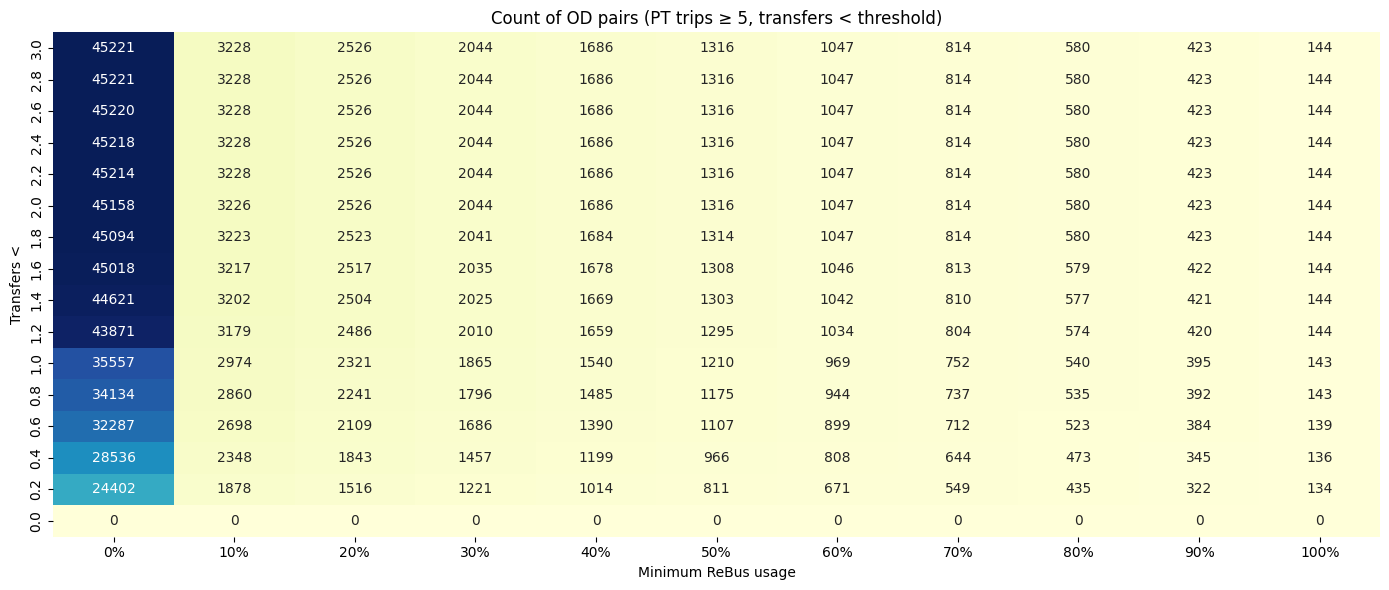

Exact count for usage_rebus ≥ 0.90, pt_transfers < 2, pt_trips ≥ 5: 3226


In [187]:
# Heatmap of remaining OD relations with consistent filters (English columns)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use the enriched OD frame
base = df_usage_rebus_enriched.copy()

# Optional: ensure one row per OD pair to avoid double counting from joins
deduplicate_by_od = True
if deduplicate_by_od and set(["origins","destinations"]).issubset(base.columns):
    base = base.drop_duplicates(subset=["origins","destinations"])

# Thresholds
usage_thresholds = np.round(np.arange(0.0, 1.01, 0.1), 2)
transfer_thresholds = np.round(np.arange(0, 3.1, 0.2), 2)
trips_threshold = 5
strict_transfers = True  # set to True to use '<'; set to False to use '≤'

# Build results
rows = []
for u in usage_thresholds:
    for t in transfer_thresholds:
        mask = (base["usage_rebus"] >= u) & \
                ((base["pt_transfers"] < t) if strict_transfers else (base["pt_transfers"] <= t)) & \
                (base["pt_trips"] >= trips_threshold)
        count = int(mask.sum())
        rows.append({
            "Transfers op": "<" if strict_transfers else "≤",
            "Transfers thr": t,
            "Usage ≥ %": int(u * 100),
            "Count": count,
        })

df_result = pd.DataFrame(rows)

# Pivot table for heatmap
y_label = f"Transfers {rows[0]['Transfers op']}"
heatmap_data = df_result.pivot(index=["Transfers thr"], columns=["Usage ≥ %"], values="Count").sort_index(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
ax.set_xticklabels([f"{int(label.get_text())}%" for label in ax.get_xticklabels()])
plt.title(f"Count of OD pairs (PT trips ≥ {trips_threshold}, transfers {rows[0]['Transfers op']} threshold)")
plt.ylabel(y_label)
plt.xlabel("Minimum ReBus usage")
plt.tight_layout()
plt.show()

# Exact check for your target thresholds (should match gdf_routing selection)
target_usage = 0.10
target_transfers = 2.0
target_trips = 5
mask_target = (base["usage_rebus"] >= target_usage) & (base["pt_transfers"] < target_transfers) & (base["pt_trips"] >= target_trips)
print("Exact count for usage_rebus ≥ 0.90, pt_transfers < 2, pt_trips ≥ 5:", int(mask_target.sum()))

## 5. Filters and selections (routing candidates, heatmaps)

Apply thresholds (usage ≥ usage_min, transfers < transfers_max_exclusive, trips ≥ trips_min). Visualize distributions and build a heatmap of OD coverage; ensure de-duplication of OD if needed.

In [190]:
# ==== Parameter ====
target_usage = 0.10
target_transfers = 2.0
target_trips = 5
strict_transfers = True  # oder False je nach Logik

# ==== Filter definieren ====
mask = (
    (df_usage_rebus_enriched["usage_rebus"] >= target_usage) &
    ((df_usage_rebus_enriched["pt_transfers"] < target_transfers) 
     if strict_transfers else 
     (df_usage_rebus_enriched["pt_transfers"] <= target_transfers)) &
    (df_usage_rebus_enriched["pt_trips"] >= target_trips)
)

# ==== Gefiltertes DataFrame ====
df_usage_filtered = df_usage_rebus_enriched[mask].copy()


In [86]:
# Load line routes shapefile, filter ReBus, and add 'line_number' (English variables)
import geopandas as gpd

# Use shapes_dir from earlier (repo_root/input/shapes/pt-data)
line_routes_file = shapes_dir / "V10_2025_lineRoute.SHP"
print("Reading line routes:", line_routes_file)
gdf_lines = gpd.read_file(line_routes_file, encoding="latin1")
print("Total line routes:", len(gdf_lines))

# Filter to ReBus only
gdf_rebus_lines = gdf_lines[gdf_lines["TSYSCODE"] == "ReBus"].copy()
print("ReBus lines:", len(gdf_rebus_lines))

# Add a 'line_number' column parsed from LINENAME after the first underscore
# Example: LINENAME like 'ReBus_123' -> line_number = '123'
gdf_rebus_lines["line_number"] = gdf_rebus_lines["LINENAME"].astype(str).str.split("_").str[1].fillna("")

# Quick preview of relevant columns
cols_preview = [c for c in ["LINENAME", "line_number", "TSYSCODE"] if c in gdf_rebus_lines.columns]
gdf_rebus_lines[cols_preview].head()

Reading line routes: C:\Users\bienzeisler\RVB-VISUM-analysis\input\shapes\pt-data\V10_2025_lineRoute.SHP
Total line routes: 32908
ReBus lines: 1075
Total line routes: 32908
ReBus lines: 1075


LINENAME line_number TSYSCODE
1979   34_430         430    ReBus
2191   13_660         660    ReBus
2213   13_660         660    ReBus
5036   13_660         660    ReBus
5287   13_660         660    ReBus

In [ ]:
# Create a 300 m buffered union per line (LINENAME) from gdf_rebus_lines
import geopandas as gpd
from shapely.ops import unary_union
from tqdm import tqdm

# Preconditions
if 'gdf_rebus_lines' not in globals():
    raise NameError("gdf_rebus_lines is not defined. Run the ReBus line loading cell first.")

lines = gdf_rebus_lines.copy()
BUFFER_METERS = 300.0

# Ensure we are in a projected CRS (meters) for buffering
crs_lines = lines.crs
if crs_lines is None:
    raise ValueError("gdf_rebus_lines has no CRS. Please set or project to a metric CRS (e.g., EPSG:32632) before buffering.")
try:
    # pyproj-style check for projected CRS (GeoPandas >= 0.10)
    is_projected = lines.crs.is_projected
except Exception:
    is_projected = True  # assume projected if check not available
if not is_projected:
    raise ValueError(f"gdf_rebus_lines CRS {crs_lines} is not projected. Please project to a metric CRS before buffering.")

# Build buffers per LINENAME
names, geoms = [], []
for name, grp in tqdm(lines.sort_values('LINENAME').groupby('LINENAME'), desc='Buffering lines', unit='line'):
    parts = [geom for geom in grp.geometry if geom is not None and not geom.is_empty]
    if not parts:
        continue
    # Buffer each segment then merge
    merged = unary_union([g.buffer(BUFFER_METERS) for g in parts])
    names.append(name)
    geoms.append(merged)

gdf_line_buffers = gpd.GeoDataFrame({"LINENAME": names, "geometry": geoms}, crs=lines.crs)
print(f"Built {len(gdf_line_buffers)} buffered line geometries (expected {lines['LINENAME'].nunique()}).")

gdf_line_buffers.head()

Buffering lines: 100%|██████████| 35/35 [00:10<00:00,  3.48line/s]

Built 35 buffered line geometries (expected 35).
Top 5 lines by intersecting destinations:
Series([], dtype: int64)



C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_23596\1340284865.py:41: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:32632

  join = gpd.sjoin(gdf_destination_filtered, gdf_line_buffers[["LINENAME", "geometry"]], predicate="intersects", how="left")


LINENAME                                           geometry
0   13_650  POLYGON ((583738.33 5761687.236, 583748.247 57...
1   13_660  POLYGON ((583581.576 5772080.539, 583597.835 5...
2   13_810  POLYGON ((597125.836 5751489.724, 597128.396 5...
3   13_830  POLYGON ((591786.152 5739786.092, 591771.852 5...
4   13_840  POLYGON ((591084.319 5740600.034, 591097.269 5...

<Axes: >

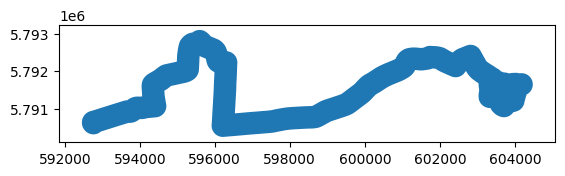

In [207]:
gdf_line_buffers[gdf_line_buffers["LINENAME"] == "34_450"].plot()

In [ ]:
import time
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from typing import Union, Optional

def filter_od_in_line_buffers(
    gdf_origin: gpd.GeoDataFrame,
    gdf_line_buffers: gpd.GeoDataFrame,
    *,
    origin_geom_col: str = "origin_geometry",     # column in gdf_origin with origin point geometry
    dest_geom_col: str = "destination_geometry",  # column in gdf_origin with destination point geometry
    origin_id_col: Optional[str] = "origins",     # set to None if you do not have IDs
    dest_id_col: Optional[str] = "destinations",  # set to None if you do not have IDs
    predicate: str = "within",                    # "within" for points inside buffers, "intersects" if touching the edge should count
    simplify_tolerance: Optional[float] = None,   # e.g., 5.0 in projected units
    line_name: Optional[str] = None,              # filter to a single LINENAME if given
    target_crs: Union[str, int, None] = None,     # reproject all inputs before processing, e.g., 25832
    drop_same_id: bool = True,                    # drop rows where origin and destination IDs are equal
    drop_same_point: bool = False,                # drop rows where origin and destination coordinates are equal
    same_point_eps: float = 0.0                   # tolerance for same point test
) -> gpd.GeoDataFrame:
    """
    Returns rows of gdf_origin for which BOTH the origin point (origin_geom_col)
    AND the destination point (dest_geom_col) lie in at least one polygon of gdf_line_buffers.

    Only gdf_origin is required. gdf_line_buffers must have columns ["LINENAME", "geometry"].

    The function preserves all columns of gdf_origin in the output.
    """

    t0 = time.time()
    print("Start filter of OD pairs by line buffers (origin only input)")

    # 0. Basic checks
    if origin_geom_col not in gdf_origin or dest_geom_col not in gdf_origin:
        raise KeyError("origin_geom_col or dest_geom_col not found in gdf_origin")

    # 1. CRS handling
    go = gpd.GeoDataFrame(gdf_origin.copy(), geometry=gdf_origin[origin_geom_col], crs=gdf_origin.crs)
    gd = gpd.GeoDataFrame(gdf_origin.copy(), geometry=gdf_origin[dest_geom_col],   crs=gdf_origin.crs)
    gb = gdf_line_buffers[["LINENAME", "geometry"]].copy()

    if target_crs is not None:
        print(f"Reproject all layers to CRS {target_crs}")
        go = go.to_crs(target_crs)
        gd = gd.to_crs(target_crs)
        gb = gb.to_crs(target_crs)
    else:
        if not (go.crs == gd.crs == gb.crs):
            raise ValueError("CRS mismatch. Set target_crs or align CRS before calling this function.")

    # (2.) Optional filter to one LINENAME
    if line_name is not None:
        print(f"Restrict buffers to LINENAME == {line_name}")
        gb = gb.loc[gb["LINENAME"] == line_name]
        if gb.empty:
            print("No buffers for requested LINENAME. Returning empty result.")
            return go.iloc[[]].copy()

    # 3. Optional simplify of buffers to speed up polygon tests
    if simplify_tolerance is not None and simplify_tolerance > 0:
        print(f"Simplify buffer geometries with tolerance {simplify_tolerance}")
        gb = gb.set_geometry(gb.geometry.simplify(simplify_tolerance, preserve_topology=True))

    print(f"Buffers count: {len(gb)}")
    print(f"Origin rows before filtering: {len(go)}")

    # 4. Drop rows with same origin and destination ID
    if drop_same_id and origin_id_col is not None and dest_id_col is not None:
        if origin_id_col not in go or dest_id_col not in go:
            print("ID columns not found. Skipping drop_same_id.")
        else:
            id_mask = go[origin_id_col] != go[dest_id_col]
            dropped = int((~id_mask).sum())
            if dropped > 0:
                print(f"Dropping {dropped} rows where origin and destination IDs are equal")
                go = go.loc[id_mask]
                gd = gd.loc[go.index]

    # (5) Optional drop rows with same origin and destination coordinates
    if drop_same_point:
        ox = go.geometry.x.to_numpy()
        oy = go.geometry.y.to_numpy()
        dx = gd.geometry.x.reindex(go.index).to_numpy()
        dy = gd.geometry.y.reindex(go.index).to_numpy()
        valid = np.isfinite(ox) & np.isfinite(oy) & np.isfinite(dx) & np.isfinite(dy)
        if same_point_eps > 0.0:
            same = valid & (np.abs(ox - dx) <= same_point_eps) & (np.abs(oy - dy) <= same_point_eps)
        else:
            same = valid & (ox == dx) & (oy == dy)
        n_same = int(same.sum())
        if n_same > 0:
            print(f"Dropping {n_same} rows where origin and destination points are identical")
            keep_mask = ~same
            go = go.loc[keep_mask]
            gd = gd.loc[go.index]

    # 6 Fast bounding box prefilter on both origin and destination points
    bxmin, bymin, bxmax, bymax = gb.total_bounds
    bbox_poly = box(bxmin, bymin, bxmax, bymax)

    mask_o_bbox = go.geometry.within(bbox_poly)
    mask_d_bbox = gd.geometry.within(bbox_poly)

    go_pref = go.loc[mask_o_bbox]
    gd_pref = gd.loc[mask_d_bbox]

    print(f"Origins prefilter kept {len(go_pref)} of {len(go)}")
    print(f"Destinations prefilter kept {len(gd_pref)} of {len(gd)}")

    # 7. Spatial joins: origin and destination must each match any buffer
    t1 = time.time()
    print(f"Spatial join origins with predicate '{predicate}'")
    o_join = gpd.sjoin(go_pref, gb, how="inner", predicate=predicate)
    origin_hits = np.unique(o_join.index.values)
    print(f"Origins matched buffers: {len(origin_hits)}")

    print(f"Spatial join destinations with predicate '{predicate}'")
    d_join = gpd.sjoin(gd_pref, gb, how="inner", predicate=predicate)
    dest_hits = np.unique(d_join.index.values)
    print(f"Destinations matched buffers: {len(dest_hits)}")
    t2 = time.time()

    # 8. Combine masks on the full index space of gdf_origin
    origin_hit_idx = pd.Index(origin_hits)
    dest_hit_idx = pd.Index(dest_hits)

    good_idx = origin_hit_idx.intersection(dest_hit_idx)
    # Make sure we only take rows that still exist in go after any filtering
    good_idx = good_idx.intersection(go.index)

    gdf_filtered = gdf_origin.loc[good_idx].copy()

    # 9. Report
    dt_total = time.time() - t0
    dt_joins = t2 - t1
    print(f"Final filtered rows: {len(gdf_filtered)}")
    print(f"Time spatial joins: {dt_joins:,.2f}s   Total time: {dt_total:,.2f}s")

    return gdf_filtered

# Usageful example:
gdf_filtered_all = filter_od_in_line_buffers(
    gdf_origin=gdf_origin,
    gdf_line_buffers=gdf_line_buffers,
    origin_geom_col="origin_geometry",
    dest_geom_col="destination_geometry",
    origin_id_col="origins",
    dest_id_col="destinations",
    predicate="intersects",
    simplify_tolerance=None,
    line_name=None,
    drop_same_id=True,
    drop_same_point=False,
    same_point_eps=0.0
)


Start filter of OD pairs by line buffers (origin only input)
Buffers count: 35
Origin rows before filtering: 4752400
Dropping 2180 rows where origin and destination IDs are equal
Buffers count: 35
Origin rows before filtering: 4752400
Dropping 2180 rows where origin and destination IDs are equal
Origins prefilter kept 2133241 of 4750220
Destinations prefilter kept 2133241 of 4750220
Spatial join origins with predicate 'intersects'
Origins prefilter kept 2133241 of 4750220
Destinations prefilter kept 2133241 of 4750220
Spatial join origins with predicate 'intersects'
Origins matched buffers: 1316116
Spatial join destinations with predicate 'intersects'
Origins matched buffers: 1316116
Spatial join destinations with predicate 'intersects'
Destinations matched buffers: 1316116
Final filtered rows: 364212
Time spatial joins: 430.64s   Total time: 435.78s
Destinations matched buffers: 1316116
Final filtered rows: 364212
Time spatial joins: 430.64s   Total time: 435.78s


## 7. Intersections and coverage (origins/destinations)

Intersect buffers with origin/destination zones. Count unique zones by ID and by geometry to avoid inflated counts from duplicates.

In [221]:
# Filter gdf_filtered_all into gdf_close_to_regio_bus_line using the requested thresholds
import pandas as pd
import geopandas as gpd

assert 'gdf_filtered_all' in globals() and isinstance(gdf_filtered_all, (pd.DataFrame, gpd.GeoDataFrame)), \
    "gdf_filtered_all not found; run the steps producing it first."

need = ['usage_rebus', 'pt_transfers', 'pt_trips']
missing = [c for c in need if c not in gdf_filtered_all.columns]
if missing:
    raise KeyError(f"gdf_filtered_all is missing required columns: {missing}")

mask = (
    (gdf_filtered_all['usage_rebus'] > 0.01) &
    (gdf_filtered_all['pt_transfers'] < 2) &
    (gdf_filtered_all['pt_trips'] > 5)
)

pre = len(gdf_filtered_all)
gdf_close_to_regio_bus_line = gdf_filtered_all.loc[mask].copy()
post = len(gdf_close_to_regio_bus_line)
print(f"gdf_close_to_regio_bus_line created from gdf_filtered_all: {post} rows (from {pre})")

gdf_close_to_regio_bus_line created from gdf_filtered_all: 3802 rows (from 364212)


In [ ]:
import pandas as pd
import geopandas as gpd

# Config: set your key column names here
KEY_ORIGIN = "origins"
KEY_DEST   = "destinations"

# 1) Ensure keys exist and de-duplicate both sources on OD keys
def _prep_keys(df: pd.DataFrame, o=KEY_ORIGIN, d=KEY_DEST) -> pd.DataFrame:
    if o not in df.columns or d not in df.columns:
        raise KeyError(f"Missing key columns '{o}' or '{d}'")
    # cast to string to avoid type-mismatch on merge
    out = df.copy()
    out[o] = out[o].astype(str)
    out[d] = out[d].astype(str)
    return out.drop_duplicates(subset=[o, d], keep="first")

df_usage_filtered = _prep_keys(df_usage_filtered)
gdf_close_to_regio_bus_line = _prep_keys(gdf_close_to_regio_bus_line)

# 2) Find OD keys present in "close_to_bus" but missing in "usage_filtered"
usage_keys = set(zip(df_usage_filtered[KEY_ORIGIN], df_usage_filtered[KEY_DEST]))
close_keys = set(zip(gdf_close_to_regio_bus_line[KEY_ORIGIN], gdf_close_to_regio_bus_line[KEY_DEST]))

missing_keys = close_keys.difference(usage_keys)
print(f"Missing OD keys to add: {len(missing_keys)}")

# 3) Extract only the missing rows from gdf_close_to_regio_bus_line
if missing_keys:
    mk_origin, mk_dest = zip(*missing_keys)  # tuples -> two lists
    mask_missing = (
        gdf_close_to_regio_bus_line[KEY_ORIGIN].isin(mk_origin)
        & gdf_close_to_regio_bus_line[KEY_DEST].isin(mk_dest)
    )
    new_rows_full = gdf_close_to_regio_bus_line.loc[mask_missing].copy()
else:
    new_rows_full = gdf_close_to_regio_bus_line.iloc[0:0].copy()  # empty same-structure

# 4) Align columns: take intersection so concat is clean
common_cols = [c for c in df_usage_filtered.columns if c in new_rows_full.columns]
new_rows = new_rows_full[common_cols].copy()

# 5) Concatenate; preserve GeoDataFrame if df_usage_filtered is GeoDataFrame
if isinstance(df_usage_filtered, gpd.GeoDataFrame):
    # If both have same CRS and geometry name, GeoPandas will keep geometry
    df_routing = pd.concat([df_usage_filtered, new_rows], ignore_index=False)
    df_routing = gpd.GeoDataFrame(df_routing, geometry=df_usage_filtered.geometry.name, crs=df_usage_filtered.crs)
else:
    df_routing = pd.concat([df_usage_filtered, new_rows], ignore_index=False)

print(f"Original df_usage_filtered: {len(df_usage_filtered)} rows")
print(f"Added new rows: {len(new_rows)}")
print(f"Updated DataFrame: {len(df_routing)} rows")

df_routing = df_routing[df_routing["usage_rebus"] >= 0.05]
print(f"After filtering usage_rebus: {len(df_routing)} rows")
# 6) Reset index for clean sequential numbering
df_routing_reset = df_routing.reset_index(drop=True)


Missing OD keys to add: 861
Original df_usage_filtered: 3226 rows
Added new rows: 2124
Updated DataFrame: 5350 rows
After filtering usage_rebus: 4853 rows


<Axes: >

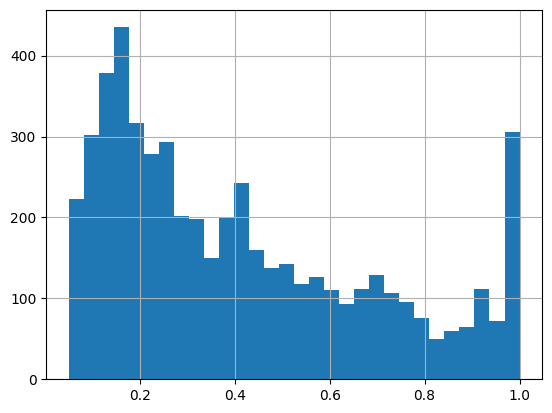

In [206]:
df_routing_reset["usage_rebus"].hist(bins=30)

### Enrich `df_routing` with connector endpoints and counts per origin/destination

Match each OD pair to its origin and destination zones from `zones_with_endpoints` and add:
- `connector_far_endpoints_origin`, `connector_far_endpoints_destination`
- `n_connectors_o`, `n_connectors_d`

In [246]:
# Join zones_with_endpoints to df_routing for origin and destination to add endpoint lists and connector counts
import pandas as pd
import geopandas as gpd

# Preconditions
assert 'df_routing' in globals() and not df_routing.empty, "df_routing missing; build routing table first."
assert 'zones_with_endpoints' in globals() and not zones_with_endpoints.empty, "zones_with_endpoints missing; compute it earlier."

# Resolve key columns
orig_col = ORIGIN_COL if 'ORIGIN_COL' in globals() and ORIGIN_COL in df_routing_reset.columns else 'origins'
dest_col = DEST_COL if 'DEST_COL' in globals() and DEST_COL in df_routing_reset.columns else 'destinations'
zone_id_col = 'NO' if 'NO' in zones_with_endpoints.columns else (KEY_ORIGIN if 'KEY_ORIGIN' in globals() else zones_with_endpoints.columns[0])

# Determine endpoint + count columns available in zones_with_endpoints
endpoints_col = 'connector_far_endpoints' if 'connector_far_endpoints' in zones_with_endpoints.columns else None
n_connectors_col = 'n_connectors' if 'n_connectors' in zones_with_endpoints.columns else None
if endpoints_col is None:
    raise KeyError("zones_with_endpoints must contain 'connector_far_endpoints'.")
if n_connectors_col is None:
    raise KeyError("zones_with_endpoints must contain 'n_connectors'.")

# Harmonize key dtypes: cast routing keys and zone ids to string to avoid object/int64 mismatches
df_routing_reset = df_routing_reset.copy()
df_routing_reset[orig_col] = df_routing_reset[orig_col].astype(str)
df_routing_reset[dest_col] = df_routing_reset[dest_col].astype(str)

zones_slim_base = zones_with_endpoints[[zone_id_col, endpoints_col, n_connectors_col]].copy()

# Build origin side mapping
zones_slim_o = zones_slim_base.rename(columns={
    endpoints_col: 'connector_far_endpoints_o',
    n_connectors_col: 'n_connectors_o'
}).copy()
zones_slim_o['zone_id_key_o'] = zones_slim_o[zone_id_col].astype(str)

# Build destination side mapping
zones_slim_d = zones_slim_base.rename(columns={
    endpoints_col: 'connector_far_endpoints_d',
    n_connectors_col: 'n_connectors_d'
}).copy()
zones_slim_d['zone_id_key_d'] = zones_slim_d[zone_id_col].astype(str)

# Origin join (explicit right_on to avoid dtype mismatch)
left = df_routing.merge(
    zones_slim_o[['zone_id_key_o', 'connector_far_endpoints_o', 'n_connectors_o']],
    left_on=orig_col,
    right_on='zone_id_key_o',
    how='left'
).drop(columns=['zone_id_key_o'])

# Destination join (use separate key column to avoid collision)
left = left.merge(
    zones_slim_d[['zone_id_key_d', 'connector_far_endpoints_d', 'n_connectors_d']],
    left_on=dest_col,
    right_on='zone_id_key_d',
    how='left'
).drop(columns=['zone_id_key_d'])

# Fill missing counts with zero and ensure ints
left['n_connectors_o'] = left['n_connectors_o'].fillna(0).astype(int)
left['n_connectors_d'] = left['n_connectors_d'].fillna(0).astype(int)

# Update df_routing
df_routing_reset = left
df_routing_OD = df_routing_reset.copy()

print("df_routing enriched with: connector_far_endpoints_o/_d and n_connectors_o/_d")
df_routing_OD

df_routing enriched with: connector_far_endpoints_o/_d and n_connectors_o/_d


origins destinations  usage_rebus  pt_transfers   pt_trips  \
0     310101901    310101902     0.199772      0.002856  22.912864   
1     310101901    310101903     0.176499      0.020194  21.427874   
2     310101901    310101905     0.160468      0.002142  26.381425   
3     310101901    310101906     0.126761      0.001530   7.532319   
4     310101901    310101907     0.122328      0.000000  12.952408   
...         ...          ...          ...           ...        ...   
4848  315803730    315803712     0.758223      0.000000  17.256473   
4849  315803730    315803716     0.760112      0.000509  44.216752   
4850  315803730    315803718     0.079595      0.000000   8.126527   
4851  315803730    315803720     0.420622      0.486363  16.467809   
4852  315803730    315803728     0.092864      0.252392  18.614890   

               origin_name      destination_name  \
0           BS Stadtkern 6        BS Stadtkern 9   
1           BS Stadtkern 6       BS Stadtkern 13   
2           BS Stadtkern 6       BS Stadtkern 15   
3           BS Stadtkern 6       BS Stadtkern 19   
4           BS Stadtkern 6        BS Stadtkern 1   
...                    ...                   ...   
4848  WB Weisse Schanze 30   WB Heinrichstadt 12   
4849  WB Weisse Schanze 30        WB Krz Holz 16   
4850  WB Weisse Schanze 30        WB Krz Holz 18   
4851  WB Weisse Schanze 30          WB Linden 20   
4852  WB Weisse Schanze 30  WB Weisse Schanze 28   

                                        origin_geometry  \
0     POLYGON ((603845.77 5791532.412, 603828.391 57...   
1     POLYGON ((603845.77 5791532.412, 603828.391 57...   
2     POLYGON ((603845.77 5791532.412, 603828.391 57...   
3     POLYGON ((603845.77 5791532.412, 603828.391 57...   
4     POLYGON ((603845.77 5791532.412, 603828.391 57...   
...                                                 ...   
4848  POLYGON ((604214.359 5780230.728, 604363.133 5...   
4849  POLYGON ((604214.359 5780230.728, 604363.133 5...   
4850  POLYGON ((604214.359 5780230.728, 604363.133 5...   
4851  POLYGON ((604214.359 5780230.728, 604363.133 5...   
4852  POLYGON ((604214.359 5780230.728, 604363.133 5...   

                                   destination_geometry  \
0     POLYGON ((603798.46 5791316.225, 603740.225 57...   
1     POLYGON ((603829.121 5790964.967, 603769.226 5...   
2     POLYGON ((603968.386 5791312.927, 603981.628 5...   
3     POLYGON ((603337.316 5791321.653, 603337.282 5...   
4     POLYGON ((603337.282 5791322.202, 603334.507 5...   
...                                                 ...   
4848  POLYGON ((605660.872 5780293.601, 605665.925 5...   
4849  POLYGON ((605170.562 5783478.749, 605166.451 5...   
4850  POLYGON ((606628.196 5781385.112, 606580.824 5...   
4851  POLYGON ((608059.761 5778529.1, 608059.637 577...   
4852  POLYGON ((604316.101 5779181.87, 604087.523 57...   

                              connector_far_endpoints_o  n_connectors_o  \
0     [POINT (603753.1947001892 5791660.670899331), ...               8   
1     [POINT (603753.1947001892 5791660.670899331), ...               8   
2     [POINT (603753.1947001892 5791660.670899331), ...               8   
3     [POINT (603753.1947001892 5791660.670899331), ...               8   
4     [POINT (603753.1947001892 5791660.670899331), ...               8   
...                                                 ...             ...   
4848  [POINT (604340.0656001947 5779700.757699319), ...               6   
4849  [POINT (604340.0656001947 5779700.757699319), ...               6   
4850  [POINT (604340.0656001947 5779700.757699319), ...               6   
4851  [POINT (604340.0656001947 5779700.757699319), ...               6   
4852  [POINT (604340.0656001947 5779700.757699319), ...               6   

                              connector_far_endpoints_d  n_connectors_d  
0     [POINT (604042.8107924324 5791528.604788725), ...               4  
1     [POINT (604018.5991001911 5791116.588899326), ...               8  
2

In [ ]:
# Export df_routing_OD with geometry-safe Parquet conversion
import os

assert 'df_routing_OD' in globals() and df_routing_OD is not None, "df_routing_OD is missing."

out_path = os.path.join(str(output_dir), "df_routing_OD.csv")
df_routing_OD.to_csv(out_path, index=False)

parquet_path_df_routing_OD = output_dir / "df_routing_OD.parquet"
# Convert geometry columns to WKB bytes to avoid ArrowTypeError




print(f"Exported updated DataFrame to: {out_path}")
print(f"Exported updated DataFrame to: {parquet_path_df_routing_OD}")
print(f"Final rows: {len(df_routing_OD)}")

ArrowInvalid: ('Could not convert <POINT (603753.195 5791660.671)> with type Point: did not recognize Python value type when inferring an Arrow data type', 'Conversion failed for column connector_far_endpoints_o with type object')

In [ ]:
# --- Export routing outputs (CSV + Parquet) with endpoint WKT packing ---
# Prepare a parquet-friendly copy: convert geometry dtypes to WKB, pack endpoint lists to WKT,
# and drop original endpoint object columns that can hold shapely geometries.

export_df = df_routing_OD.copy()

# Add WKT columns for endpoints
export_df = endpoints_to_wkt(export_df, ["connector_far_endpoints_o", "connector_far_endpoints_d"], suffix="_wkt")

# Drop original endpoint object columns to avoid ArrowInvalid
for col in ["connector_far_endpoints_o", "connector_far_endpoints_d"]:
    if col in export_df.columns:
        export_df = export_df.drop(columns=[col])

# Ensure plain types for keys to avoid surprises
for key_col in [ORIGIN_COL, DEST_COL]:
    if key_col in safe_export_df.columns:
        safe_export_df[key_col] = safe_export_df[key_col].astype(str)

# Write CSV
csv_out = output_dir / "df_routing_OD.csv"
safe_export_df.to_csv(csv_out, index=False, encoding="utf-8")
print(f"Wrote CSV: {csv_out}")

# Write Parquet
pq_out = output_dir / "df_routing_OD.parquet"
safe_export_df.to_parquet(pq_out, index=False)
print(f"Wrote Parquet: {pq_out}")